# Import Modules

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

import utils

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [62]:
train_source_X = pd.read_csv("./deep_occupancy_detection/data/2_X_train.csv").values
target_X = pd.read_csv("./deep_occupancy_detection/data/1_X_train.csv").values
train_source_y_task = pd.read_csv("./deep_occupancy_detection/data/2_Y_train.csv").values.reshape(-1)
target_y_task = pd.read_csv("./deep_occupancy_detection/data/1_Y_train.csv").values.reshape(-1)

scaler = preprocessing.StandardScaler()
train_source_X = scaler.fit_transform(train_source_X)
target_X = scaler.fit_transform(target_X)

In [63]:
train_source_X, train_source_y_task = utils.apply_sliding_window(train_source_X, train_source_y_task, filter_len=3)
target_X, target_y_task = utils.apply_sliding_window(target_X, target_y_task, filter_len=3)
_, test_target_X, _, test_target_y_task = train_test_split(target_X, target_y_task, test_size=0.3, shuffle=False)

In [64]:
train_source_X = torch.tensor(train_source_X, dtype=torch.float32)
train_source_y_task = torch.tensor(train_source_y_task, dtype=torch.float32)
test_target_X = torch.tensor(test_target_X, dtype=torch.float32)
test_target_y_task = torch.tensor(test_target_y_task, dtype=torch.float32)

train_source_X = train_source_X.to(device)
train_source_y_task = train_source_y_task.to(device)
test_target_X = test_target_X.to(device)
test_target_y_task = test_target_y_task.to(device)

source_ds = TensorDataset(train_source_X, train_source_y_task)
source_loader = DataLoader(source_ds, batch_size=34, shuffle=True)

# Benchmark1. ecodataset_rnn_overlapwindow.ipynb - Domain Classifier, Target Data

In [65]:
hidden_size = 128
num_classes = 1
learning_rate = 0.01

feature_extractor = utils.ManyToOneRNN(input_size=train_source_X.shape[2], hidden_size=hidden_size, num_layers=1).to(device)
task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(device)

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

Text(0, 0.5, 'Binary Cross Entropy')

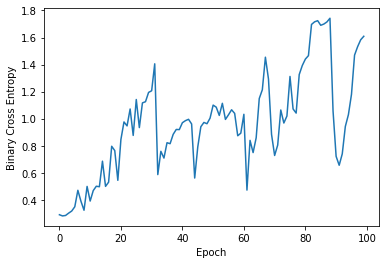

In [66]:
num_epochs = 100
losses = []
for _ in range(num_epochs):
    feature_extractor.train()
    task_classifier.train()

    for source_X_batch, source_y_task_batch in source_loader:
        # 1. Forward
        pred_y_task = task_classifier(feature_extractor(source_X_batch))
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        loss = criterion(pred_y_task, source_y_task_batch)
        
        # 2. Backward
        task_optimizer.zero_grad()
        feature_optimizer.zero_grad()
        loss.backward()
        

        # 3. Update Params
        feature_optimizer.step()
        task_optimizer.step()
    
    # 4. Evaluation
    feature_extractor.eval()
    task_classifier.eval()
    with torch.no_grad():
        pred_y_task = task_classifier(feature_extractor(test_target_X))
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        loss = criterion(pred_y_task, test_target_y_task)
        losses.append(loss.item())

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy")

In [67]:
pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == test_target_y_task) / pred_y_task.shape[0]
print(f"Many To One RNN Accuracy: {acc}")

Many To One RNN Accuracy: 0.8725490570068359


# Benchmark2. Random Forest

# Benchmark3. SVM

# Benchmark4. BiLSTM-Attention